# Загрузка данных в среду

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install zipfile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [3]:
import zipfile
z = zipfile.ZipFile("/content/drive/MyDrive/text-recognition.zip")

In [4]:
z.extractall()

# Подготовка данных

In [5]:
!pip install opencv-python

In [6]:
!pip install neptune-client

In [7]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from pathlib import Path
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt

In [8]:
os.environ["NEPTUNE_API_TOKEN"] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwYTk5MTQwZC1mYmVmLTQ1MTItYjA0ZC05NTdjYzNjNjRhMmEifQ=='

In [9]:
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import trange
import neptune.new as neptune
run = neptune.init(
    api_token= os.getenv('NEPTUNE_API_TOKEN'),
    project = 'misha/text-recognition-with-crnn'
)

https://app.neptune.ai/misha/text-recognition-with-crnn/e/CRNN-5
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### разделение текстов по строчкам

In [10]:
train_dir = Path('/content/B.TextRecognition/Train')
test_dir = Path('/content/B.TextRecognition/Test')

In [11]:
train_data = []
train_labels = []

In [12]:
os.remove('/content/B.TextRecognition/Train/source_535.png')
os.remove('/content/B.TextRecognition/Train/source_580.png')
os.remove('/content/B.TextRecognition/Train/source_621.png')

In [13]:
for img in train_dir.rglob('*.png'):
    image = cv2.imread(str(img))
    train_data.extend([image[i*49:(i+1)*49,:] for i in range(24)])
    with open(str(img)[:-4]+'.txt', 'r') as label_text:
        train_labels.extend(label_text.read().splitlines())

In [14]:
len(train_labels)

16704

devonshire we of do discretion Enjoyment discourse ye 


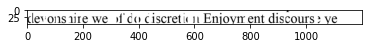

In [15]:
val = np.random.randint(1,16704)
plt.imshow(train_data[val])
print(train_labels[val])

In [16]:
test_data = []

In [17]:
for img in test_dir.rglob('*.png'):
    image = cv2.imread(str(img))
    test_data.extend([image[i*49:(i+1)*49,:] for i in range(24)])

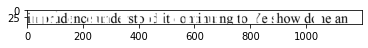

In [18]:
plt.imshow(test_data[np.random.randint(1,2352)])

# Разделим датасет на обучающую и валидационную выборки

In [19]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [20]:
from sklearn.model_selection import train_test_split
train_files, val_files, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25)

In [21]:
train_files.shape

(12528, 49, 1200, 3)

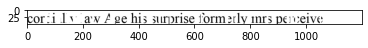

In [22]:
plt.imshow(train_files[7])

# Configurations

In [23]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config_json = {
    "alphabet": set(' '.join(train_labels)),
    "save_dir": "experiments/test",
    "num_epochs": 10,
    "image": {
        "width": 1152,
        "height": 64
    },
    "train": {
        "batch_size": 64
    },
    "val": {
        "batch_size": 64
    }
}

# Токенайзер для преобразования текста в массив чисел

# CTC loss (The Connectionist Temporal Classification loss)

#### Основная идея в том, что картинка разбивается на какое-то фиксированоое количество вертикальных областей (количество этих областей значительно болше количества символов). Для каждой области вычисляется вероятность нахождения в ней буквы, для каждой буквы из алфавита. В случае, если в слове идут две буквы подряд, то с помощью такой идеи их трудно было бы различить. Для этого между одинаковыми буквами вставляется символ CTC BLANK

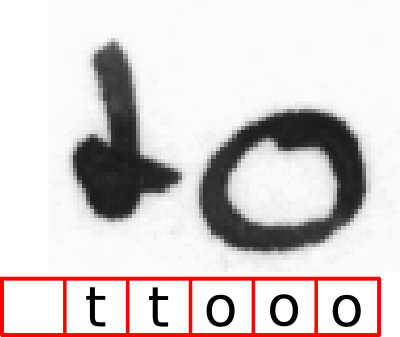

In [24]:
OOV = '<OOV>' # out of vocabulary symbol
CTC_BLANK = '<BLANK>'
def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char for CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    # словарь символов из всех символов алфавита + первые два: OOV, CTC BLANK
    char_map[CTC_BLANK] = 0
    char_map[OOV] = 1
    return char_map

class Tokenizer:
    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet) # словарь символов алфавита для перевода строки в список чисел
        self.rev_char_map = {val: key for key, val in self.char_map.items()} # словарь для обратного перевода чисел в символы

    def encode(self, line_list):  
        """Returns a list of encoded lines (int)."""
        enc_lines = []
        for line in line_list: # представляем одну строку с транскрипцией для картинки в виде списка чисел
            enc_lines.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV] # кодируем символы их значениями, а неизвестные - значением OOV
                 for char in line]
            )
        return enc_lines

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_line_list): # на входе батч из списков кодирующих строки
        """Returns a list of lines (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_lines = []
        for line in enc_line_list: # декодируем каждую строку(список кодирующих чисел) из списка строк-транскрипций
            line_chars = ''
            for idx, char_enc in enumerate(line):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV] # символ - не out of vocabulary
                    and char_enc != self.char_map[CTC_BLANK] # символ - не CTC BLANK
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == line[idx - 1]) # если одинаковые кодовые числа, то не выводим несколько раз одно и то же число
                ): # если числа и правда повторяются, то между ними должен быть CTC BLANK
                    line_chars += self.rev_char_map[char_enc]
            dec_lines.append(line_chars)
        return dec_lines

# DATASET CLASS

In [25]:
class OCRDataset(Dataset):
    def __init__(self, images, labels, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        self.data_len = len(images)

        self.imgs = images
        self.texts = labels # список строк транскипций к картинкам
        self.enc_texts = tokenizer.encode(labels) # получим списков закодированных строк
        #используем метод из класса токенизатора

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx]) # вернет одномерный список, закодированной строки
        image = self.imgs[idx]
        if self.transform is not None: #делаем трансформации
            image = self.transform(self.imgs[idx])
        return image, text, enc_text
        #возвращает изображение, строку с транскрипцией и закодированную строку с транскипцией(список чисел)


# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch): # принимает кортеж, и использует __getitem__ of Dataset class
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0) # по оси 0 объединяем два тензора в один
    text_lens = torch.LongTensor([len(text) for text in texts])
    #!!!!# pad_sequence - стекует список тензоров и дополняет, если надо, их до нужной длины
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens
    # возвращает батч-кортеж

def get_data_loader(
    transforms, images, labels, tokenizer, batch_size, drop_last
):
    dataset = OCRDataset(images, labels, tokenizer, transforms)
    data_loader = torch.utils.data.DataLoader( 
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=8,
    ) # DataLoader использующий прописанный нами класс Dataset с magic методами
    # __getitem__, __len__, __init__
    return data_loader

# Расстояние Левенштйна

In [26]:
%pip install python-Levenshtein

In [27]:
import Levenshtein

# Аугментация

In [28]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

In [62]:
class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr).permute(2,0,1)
        return arr

class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image

class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img

def get_train_transforms(height, width):
    transforms = Compose([
        ImageResize(height, width),
        Normalize(),
        ToTensor()
    ])
    return transforms


def get_val_transforms(height, width):
    transforms = Compose([
        ImageResize(height, width),
        Normalize(),
        ToTensor()
    ])
    return transforms

# Model

In [47]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    # number_class_symbols - количество различных символов в транскрипциях
    # time_feature_count - количество признаков на входе LSTM
    def __init__(
        self, number_class_symbols, time_feature_count=640, lstm_hidden=640,
        lstm_len=2,
    ):
        super().__init__()
        #pretrained_feature_extractor = torchvision.models.efficientnet_b5(pretrained=True)
        model = torchvision.models.resnet34(pretrained=True) # берем Conv2D слои предобученного резнета в качестве feature_extractor
        
        blocks = [model.conv1, model.bn1, model.relu,
              model.maxpool, model.layer1, model.layer2, model.layer3]
        self.feature_extractor = nn.Sequential(*blocks) 
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count)) # в скобках указывается output size для каждой карты
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len, dropout=0.1)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )
    def forward(self, x):
        # shape [64, 3, 64, 1152] : 64 - batch size, 3 - channels, 64 - heigth, 1152 - width
        # 3 cards 2 x 40
        x = self.feature_extractor(x)
        # shape [64, 256, 4, 72] : got 256 cards  4 x 72
        b, c, h, w = x.size()
        x = x.view(b, c * h, w) # stack cards by heigth
        # shape [64, 1024, 72] : got 1 card 1024 x 32
        x = self.avg_pool(x)
        # shape [64, 640, 640] : got card 256 x 256
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        # shape [64, 640, 1280]
        x = self.classifier(x)
        # shape [64, 640, 65] # shape[2] - количество классов(количество различных символов в словаре)
        #shape[0] - размер батча, shape[1] - длина последовательности
        # т е имеем shape[1] вертикальных областей на которых разбивается каждая картинка и shape[2] - вероятностей принадлежности области к определенному символу
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        # permute - переставляет измерения местами (5,4,3) -> (4,5,3)
        # ПОДГОНЯЕМ ПОД ФОРМУ ДЛЯ ПОДСЧЕТА LOSS: (T, N, C), где 
        #T - Input sequence length, C - Number of classes (including blank), N - Batch size
        return x

# Цикл обучения

In [48]:
def fit_epoch(train_loader, model, criterion, optimizer, scheduler, tokenizer):
    total_loss=0
    num_batches=0
    # переключаем модель в режим обучения, теперь она может обновлять веса
    model.train()
    #scheduler.step()
    for images, texts, enc_pad_texts, text_lens in train_loader:
        optimizer.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(texts)
        predictions = model(images)
        
        output_lenghts = torch.full(
            size=(predictions.size(1),),
            fill_value=predictions.size(0),
            dtype=torch.long
        )
        loss = criterion(predictions, enc_pad_texts, output_lenghts, text_lens)
        # (input, target, input_lengths, target_lengths)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        # predictions имеют вид: (T, N, C), где 
        #T - Input sequence length, C - Number of classes (including blank), N - Batch size
        # получаем предсказания символа в каждой вертикальной области, а затем декодируем это в строку 
        pred = torch.argmax(predictions.detach().cpu(), -1).permute(1, 0).numpy()
        text_preds = tokenizer.decode(pred)
        # count total loss per batch
        loss_item = sum([Levenshtein.distance(text1, text2) 
        for text1, text2 in zip(text_preds, texts)])
        total_loss += loss_item
        run["train/loss"].log(loss_item)
        num_batches +=1
    return total_loss/num_batches

def eval_epoch(model, val_loader, criterion, tokenizer):
  total_loss=0
  num_batches=0
  for images, texts, _, _ in val_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, DEVICE)
        loss_item = sum([Levenshtein.distance(text1, text2) 
                    for text1, text2 in zip(text_preds, texts)])
        total_loss += loss_item
        run["eval/loss"].log(loss_item)
        num_batches +=1
  return total_loss/num_batches
   
def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds

In [49]:
def train(config, train_files, val_files, train_labels, val_labels):
    tokenizer = Tokenizer(config['alphabet'])
    # transforms
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    # data loaders
    train_loader = get_data_loader(
        train_transforms,
        train_files,
        train_labels,
        tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True)
    val_loader = get_data_loader(
        val_transforms,
        val_files,
        val_labels,
        tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=True)
    os.makedirs(config['save_dir'], exist_ok=True)
    # объявляем модель
    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.to(DEVICE)
    # устанавливаем оценщик для loss function(ctc_loss)
    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    #blank - номер символа blank ctc, 
    #reduction='mean' - output losses will be divided by the target lengths 
    #and then the mean over the batch is taken
    
    #объявляем оптимизатор
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='max', factor=0.5, patience=15)

    run['model/parameters/n_epochs'] = config['num_epochs']

    for epoch in trange(config['num_epochs'], desc="Epoch:"):
        train_loss = fit_epoch(train_loader, model, criterion, optimizer, scheduler, tokenizer)
        val_loss = eval_epoch(model, val_loader, criterion, tokenizer)
        run['train/epoch/loss'].log(train_loss)
        run["evaluation/loss"] = val_loss
        model_save_path = os.path.join(
             config['save_dir'], f'model-{epoch}.ckpt')
        torch.save(model.state_dict(), model_save_path)
        print('Model weights saved')

In [33]:
train(config_json, train_files, val_files, train_labels, val_labels)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch::  10%|█         | 1/10 [07:08<1:04:16, 428.50s/it]

Model weights saved


Epoch::  20%|██        | 2/10 [14:29<58:05, 435.66s/it]  

Model weights saved


Epoch::  30%|███       | 3/10 [21:50<51:09, 438.44s/it]

Model weights saved


Epoch::  40%|████      | 4/10 [29:13<43:59, 439.97s/it]

Model weights saved


Epoch::  50%|█████     | 5/10 [36:34<36:41, 440.28s/it]

Model weights saved


Epoch::  60%|██████    | 6/10 [43:53<29:20, 440.04s/it]

Model weights saved


Epoch::  70%|███████   | 7/10 [51:13<21:59, 439.96s/it]

Model weights saved


Epoch::  80%|████████  | 8/10 [58:33<14:40, 440.12s/it]

Model weights saved


Epoch::  90%|█████████ | 9/10 [1:05:55<07:20, 440.60s/it]

Model weights saved


Epoch:: 100%|██████████| 10/10 [1:13:16<00:00, 439.66s/it]

Model weights saved


# Predictions

In [ ]:
model_crnn = CRNN(number_class_symbols=Tokenizer(config_json['alphabet']).get_num_chars())
model_crnn.load_state_dict(torch.load('/content/experiments/test/model-9.ckpt'))
model_crnn.to(DEVICE)

In [53]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

In [54]:
predictor = OcrPredictor(
    model_path='/content/experiments/test/model-9.ckpt',
    config=config_json
)

(64, 1152, 3)


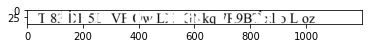

(64, 1152, 3)
Prediction:   JT 83 DH5L VF Ow LO GNkq 7R9BT xl o L oz
(64, 1152, 3)


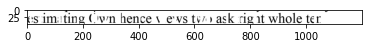

(64, 1152, 3)
Prediction:  estimatiing Own hence wiews two ask right whole ten 
(64, 1152, 3)


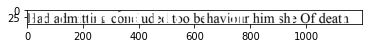

(64, 1152, 3)
Prediction:  Had admitting concluded too behaviour him she Of death 
(64, 1152, 3)


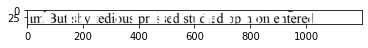

(64, 1152, 3)
Prediction:  am But shy tedious pressed studied ophion entered 
(64, 1152, 3)


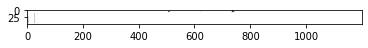

(64, 1152, 3)
Prediction:  alll
(64, 1152, 3)


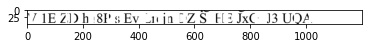

(64, 1152, 3)
Prediction:  V 1E ZD ha8P s Ev Lrejn DZ S HE JxG  J3 UQA
(64, 1152, 3)


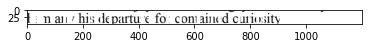

(64, 1152, 3)
Prediction:  ham any his departure fon contained curiosity 
(64, 1152, 3)


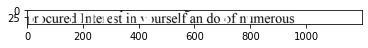

(64, 1152, 3)
Prediction:  procured Interest in yourself an do of numerous 
(64, 1152, 3)


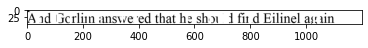

(64, 1152, 3)
Prediction:  And Gorlim answered that he should find Eilinel again 
(64, 1152, 3)


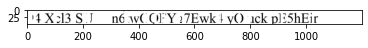

(64, 1152, 3)
Prediction:   4 Xcl3 SUJn6twCQFYg7Ewk4 yO uck pE5hEir


In [64]:
pred_json = {}
count = 0

for idx in np.random.randint(0, len(test_data), 10):
    img = test_data[idx]
    pred = predictor(img)
    #pred_json[img_name] = pred

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    print('Prediction: ', predictor(img))
    count += 1